# Baseline

## Set-up
- Download the [Depresjon dataset](https://datasets.simula.no/depresjon/), unpack it, and place it in the current directory.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

## Data
We generate two datasets for our baseline:
- Logistic regression: with the mean and standard deviation of a given person's activity as our two features
- Naive Bayes: with counts of discretized actigraph measurements as our features

<font color='red'>Should we use the cutoff for both models?</font>

In [2]:
data_dir = 'data'
n = len(os.listdir(os.path.join(data_dir, 'condition'))) + len(os.listdir(os.path.join(data_dir, 'control')))
cutoff = 19299  # for ensuring equal number of data points per person

bin_sz = 40
max_activation = 8000
bins = range(0, max_activation, bin_sz)

X_lr = np.empty((n, 2))
X_nb = np.zeros((n, len(bins)), dtype=np.int32)
y = np.empty((n,))

i = 0
for k, v in {'condition': 1, 'control': 0}.items():
    for f in os.listdir(os.path.join(data_dir, k)):
        activity = np.genfromtxt(os.path.join(data_dir, k, f), delimiter=',', skip_header=True, usecols=[2])[:cutoff]
        X_lr[i, :] = np.array([np.mean(activity), np.std(activity)])
        discretized_activity = np.digitize(activity, bins)
        bin_idxs, counts = np.unique(discretized_activity, return_counts=True)
        for bin_idx, count in zip(bin_idxs, counts):
            X_nb[i, bin_idx - 1] = count
        y[i] = v
        i += 1

## Models

We set up 11-fold cross validation for our models.

In [3]:
folds = int(n / 5)

We evaluate with accuracy, F1 score, and AUC.

In [4]:
def eval_model(X, y, clf, folds):
    metrics = ['accuracy', 'f1', 'roc_auc']
    result = cross_validate(clf, X, y, cv=folds, scoring=metrics)
    for metric in metrics:
        print(metric, ':', np.mean(result['test_{}'.format(metric)]))

### Logistic Regression

In [5]:
clf = LogisticRegressionCV(cv=folds).fit(X_lr, y)
y_pred = clf.predict(X_lr)
acc = clf.score(X_lr, y)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_pred)
print('Acc: ', acc)
print('F1: ', f1)
print('AUC: ', auc)

Acc:  0.7636363636363637
F1:  0.711111111111111
AUC:  0.7540760869565217


We plot the points and decision boundary.

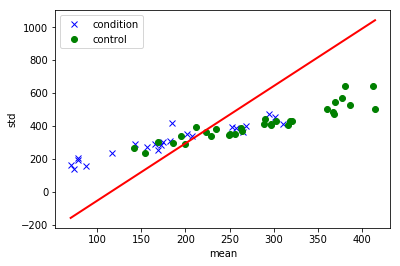

In [6]:
# Code for plotting taken from CS 229 assignments.
plt.figure()
plt.plot(X_lr[y == 1, -2], X_lr[y == 1, -1], 'bx', linewidth=2, label='condition')
plt.plot(X_lr[y == 0, -2], X_lr[y == 0, -1], 'go', linewidth=2, label='control')

# Plot decision boundary (found by solving for theta^T x = 0).
x1 = np.arange(min(X_lr[:, -2]), max(X_lr[:, -2]), 0.01)
x2 = -(clf.intercept_[0] / clf.coef_[0][1] + clf.coef_[0][0] / clf.coef_[0][1] * x1)
plt.plot(x1, x2, c='red', linewidth=2)

# Add labels and display.
plt.xlabel('mean')
plt.ylabel('std')
plt.legend()
plt.show()

### Logistic Regression II
<font color='red'>Using this implementation gives different numbers. Any insights/thoughts on what we should use?</font>

In [7]:
eval_model(X_lr, y, LogisticRegression(), folds)

accuracy : 0.7469696969696972
f1 : 0.6787878787878788
roc_auc : 0.8611111111111112


### Naive Bayes

In [8]:
eval_model(X_nb, y, MultinomialNB(), folds)

accuracy : 0.7424242424242425
f1 : 0.693939393939394
roc_auc : 0.8055555555555555
